# PAF Backend Simulation

The `pafsim`-module contains a set of backend processors (Correlator, Channelizer, Beamformer etc.). Processors are combined to a signal processing chain allowing to simulate the processing of a PAF backend.

This notebook shows how to use the `pafsim`-module.

In [2]:
import pafsim
import pafsim.processor as pp

## Processors
A concrete processor inherits from the base class `Processor`. Every processor implements one or multiple algorithms. For instance, the Channelizer-class implements a polyphase filterbank (PFB) and a FFT-based channelization. The `mode`-parameter allows to select the desired algorithm. (All processors have shared and unshared parameter besides the `mode` parameter)

An example of instantiating processors may look like the following code.

In [4]:
channelizer = pp.Channelizer("channelizer1", mode="fft", channels=128, window="hamming")
generator = pp.WaveformGenerator("siggen1", mode="sinus", fs=1e4, duration=1.024, freq=[500,2.5e3,3.9e3])

Now, that we have created two processor objects, we can chain them together.

In [5]:
channelizer.setPreProcessor(generator)

Internally, the method `setPreProcessor` creates a Connector-object validating the connection between the two processors. A connection is valid when the dimensions of the pre-processor output can be transposed into the dimension of the expected input.

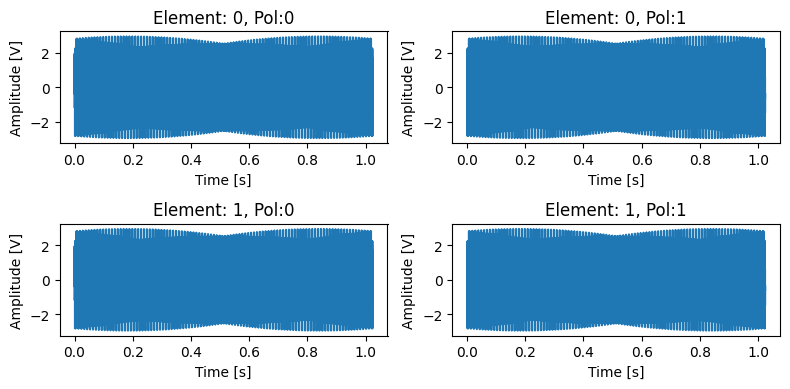

In [6]:
generator.process()
generator.plot()

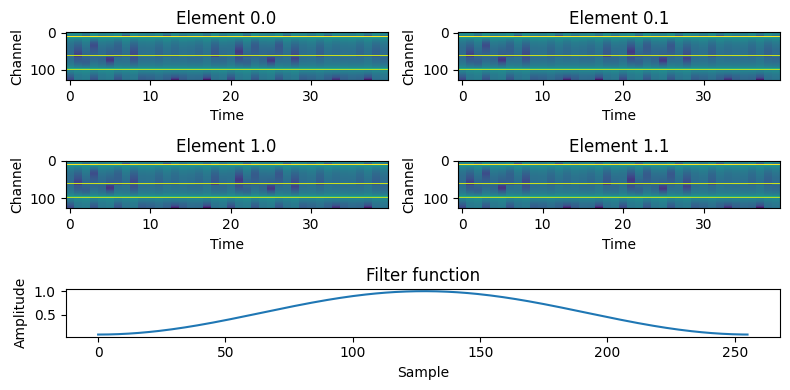

In [7]:
channelizer.process()
channelizer.plot()

## Processing Chain

For comprehensive simulation where several processors are desired, the ProcessingChain class is more applicable to use. The chain can be configured by passing a dictionary, or by addind processors using `addProcessor()`. Here, we discuss the dictionary option.

### Configure a Processor
A processor in the chain is specified in the configuration as subdictionary
```
"name of the processor":
{
    "processor":"Classname of processor",
    "input":["ID of pre-processor #1","ID of pre-processor #2"]
    # processor specific parameters
}   
```

### Example 1: Beamweight Calibration (maxSNR)

Below is an example configuration for calibrating beam weights, we need the following components. 
1. `SignalGenerator`: create signals using the SignalGenerator component. In future, the PAFFrontendSim is used (Workpackage: 3.1.3).
2. `Channelizer`: Apply a fft-based channelization
3. `Correlator`: Correlate individual elements / signals an create array covariance matrices (ACMs)
4. `WeigthGenerator`: Use the correlation results to estimate beamweights with the `maxsnr` algorithm

In [10]:
calibration_conf = {
    "signalgenerator" :{ # name of the processor
      "processor":"WaveformGenerator",      # classname of processor
      # Processor specific paramters
      "mode":"noise",   # mode of signal generation. (noise, sawtooth, loadFromFile etc.)
      "duration":8.192, # duration of the signal [s]
      "fs":1e5,         # sample frequency [Hz]
      "antennas":4,     # Number of antennas / elements
      "pol":2           # Number of polarizations
    },
    "channelizer":{
      "processor":"Channelizer",
      "input":"signalgenerator",
      "mode":"fft",
      "window":"hamming",
      "taps":2,
      "channels":64
    },
    "correlator":{
      "processor":"Correlator",
      "input":"channelizer",
      "mode":"acm",
      "acc":4 # For each beam we need an on- and off-source ACM
    },
    "weightgenerator":{
      "processor":"WeightGenerator",
      "input":"correlator",
      "mode":"maxsnr",
      "beams":2
    },
    "store":["correlator", "weightgenerator"], # Store results of the WG -> data is available for other processing chains
    "location":"calibration/" # Storage location
}

#### Run the Calibration Chain

The `calibration_conf` is passed to the `ProcessingChain`-object. The chain creates the specified `Processor`-objects and links them together with `Connection`-objects.

In [11]:
chain1 = pafsim.ProcessingChain(calibration_conf, name="calibration") # Instatiation
chain1.setup() # Creation and linking of processors
chain1.process() # Process the data
chain1.save(plot=True) # Store data and plots of the specified procesors ("store":["correlator", "weightgenerator"])

/home/niclas/venv/pafsim/lib/python3.8/site-packages/pafsim/processor/channelizer.py:108: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


A few things to note here
- The `setup`-method must be called before `process()`, otherwise an exception is thrown.
- The `save()`-method creates a folder structure with subfolders `data` and `plot`.
    - `data` contains the output vectors of the specified processors. 
    - `plot` contains PNG images of the output data.

#### Show some plots
The ProcessingChain-Class provides two methods:
- `plot()`: Plots the directed acycle graph (DAG) of the chain
- `plotAll()`: Plots all output products of the processors

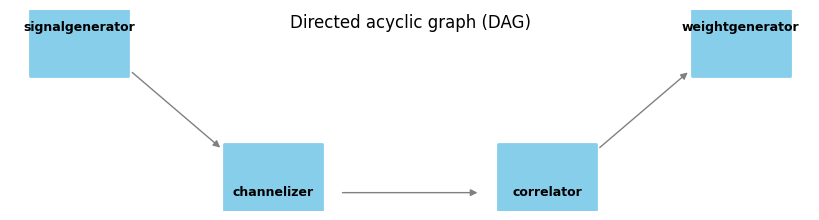

In [12]:
chain1.plot(figsize=(8,2))
#chain.plotAll() # Not used, as too many plots at a time

However, we access and plot the different processors individually.

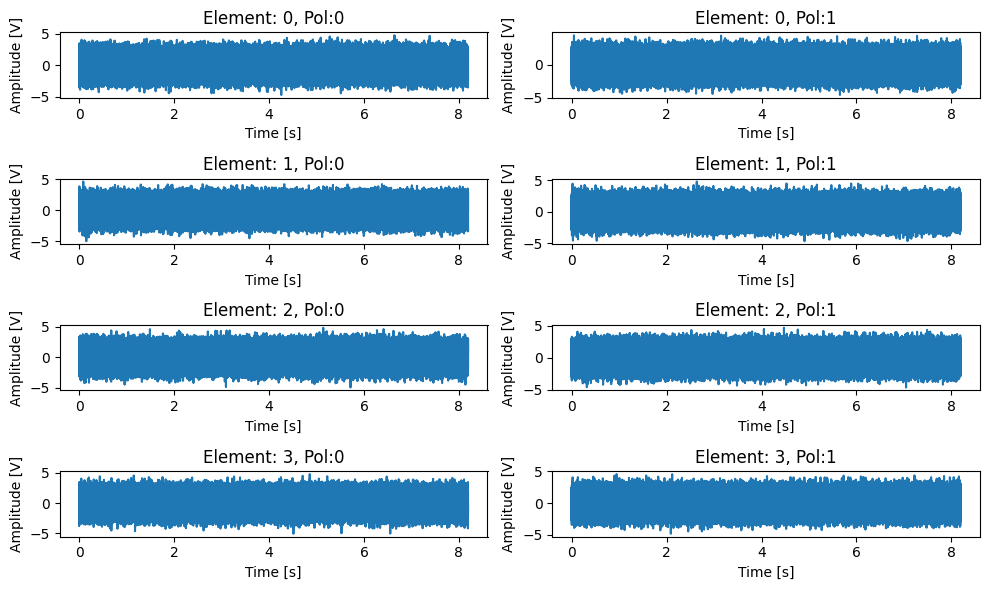

In [13]:
chain1.getProcessor("signalgenerator").plot(figsize=(10,6))

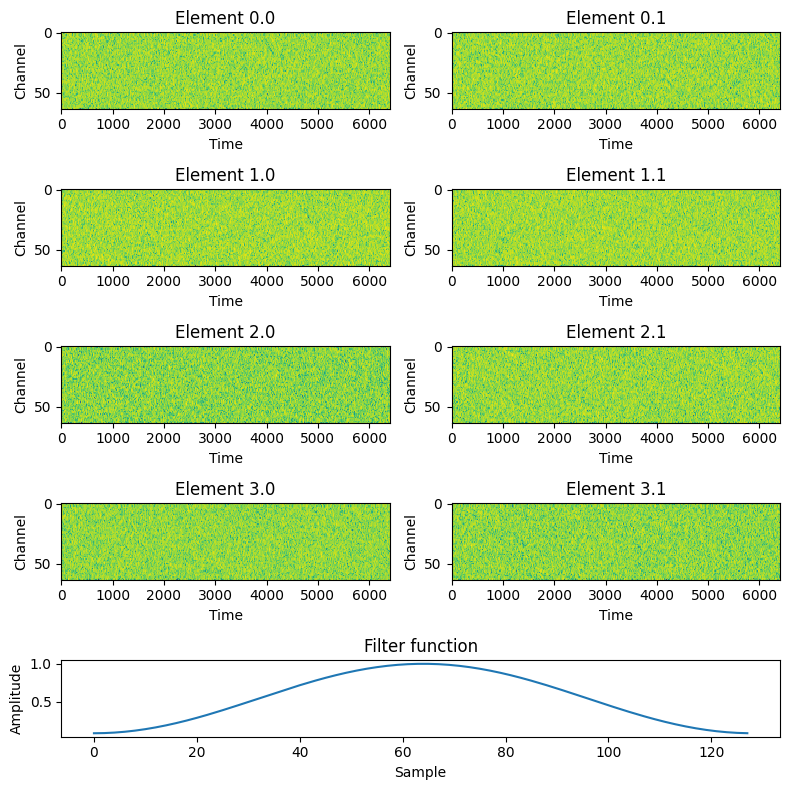

In [14]:
chain1.getProcessor("channelizer").plot(figsize=(8,8))

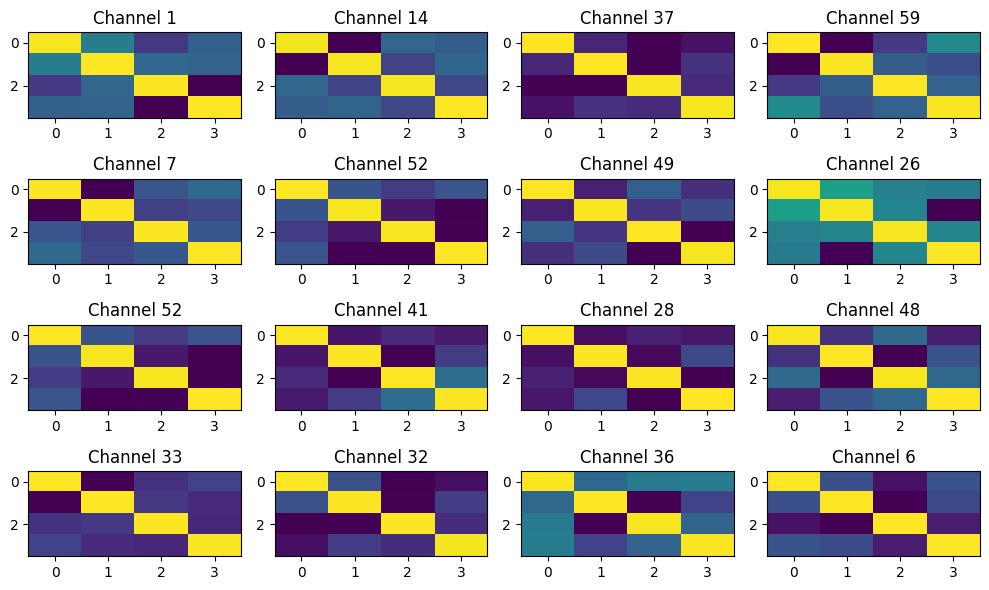

In [15]:
chain1.getProcessor("correlator").plot(figsize=(10,6))

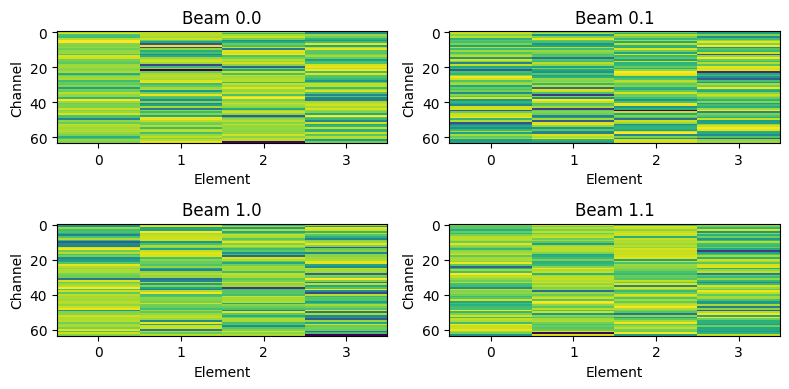

In [16]:
chain1.getProcessor("weightgenerator").plot()

### Example 2: Beamforming with calibrated Weights
As in the previous example we create a configuration. The result from the previous calibration is used by reusing the data from the WeightGenerator.

Note: The configuration must match the configuration from the calibration simulation. For example, it is not possible to have different numbers of antennas or beams, because this simulation depends on the calibration simulation. 

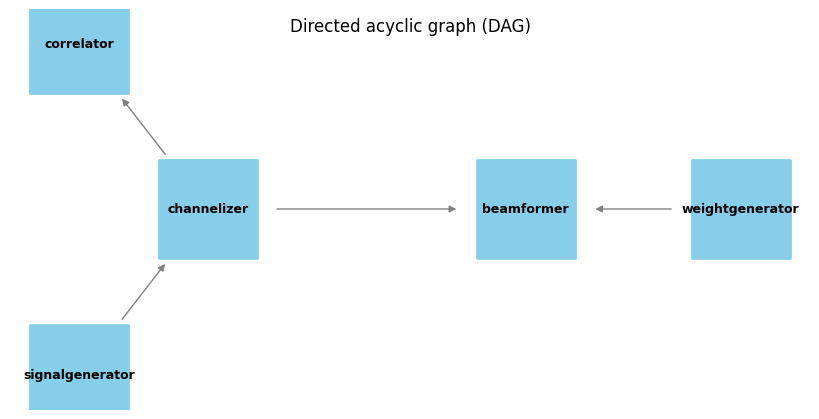

In [18]:
beamform_conf = {
    "signalgenerator" :{
        "processor":"WaveformGenerator",
        "mode":"noise",
        "duration":16.384,
        "fs":1e4,
        "antennas":4,
        "pol":2
    },
    "channelizer":{
        "processor":"Channelizer",
        "mode":"fft",
        "taps":8,
        "channels":64,
        "dmode":"int8",
        "input":"signalgenerator"
    },
    "beamformer":{
      "processor":"Beamformer",
      "mode":"voltage",
      "input":["channelizer","weightgenerator"]
    },
    "correlator":{
      "processor":"Correlator",
      "mode":"acm",
      "input":"channelizer"
    },
    "weightgenerator":{
      "processor":"WeightGenerator",
      "mode":"load",
      "path":"calibration/data/weightgenerator.pk1" # Here, we load the calibrated data from the calibration simulation
    }
}
chain2 = pafsim.ProcessingChain(beamform_conf) # instantiation
chain2.setup()                     # Create processors and build a DAG'
chain2.plot()
chain2.process()                   # computes the test data according to the passed configuration

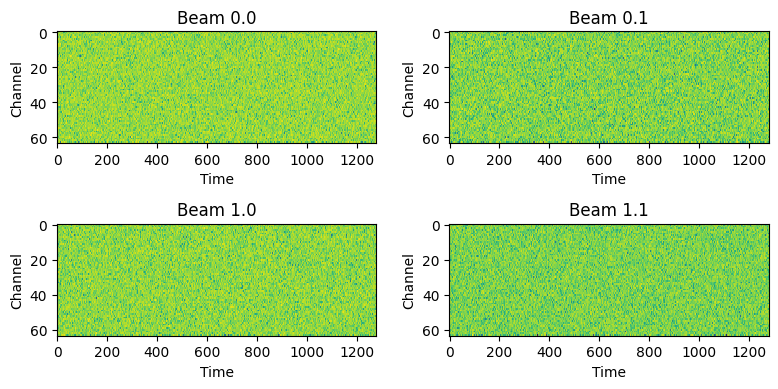

In [19]:
beamformer = chain2.getProcessor("beamformer")
beamformer.plot()

## Executor
The Executor links a set of ProcessingChains together and resolves the dependencies of the chains. Basically, the Executor is a ProcessingChain-object tht connects ProcessingChains instead of Processors. In future, it provides an evaluation metric, for comparing and benchmarking different simulations against each other.

### Example 2.1:
A simple example is to link the previous chains together. We already stated that the second chain relys on the first (beam weights).

Creating ProcessingChain for simulation calibration
Creating ProcessingChain for simulation beamforming


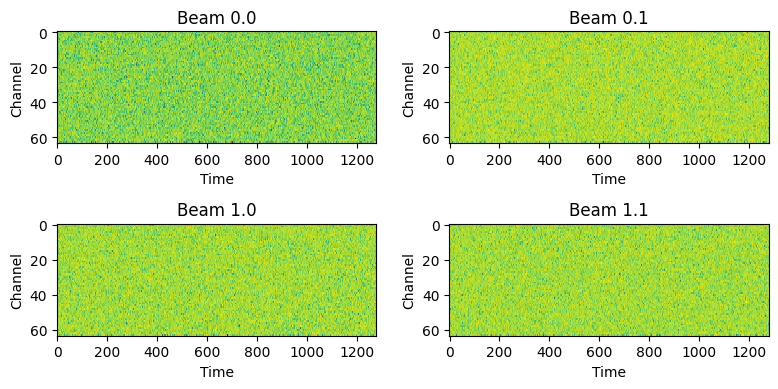

In [20]:
simulation_conf = {
    "calibration": calibration_conf,
    "beamforming": beamform_conf
}
simulation_conf["beamforming"]["dependency"] = "calibration" # Set the dependency
executor = pafsim.Executor(simulation_conf)
executor.run()
executor.getChain("beamforming").getProcessor("beamformer").plot()